In [1]:
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
import os
import re
import numpy as np
from itertools import permutations,combinations
import requests
# from matplotlib_venn import venn3, venn3_circles
import shutil
from plumbum.cmd import obabel
from rdkit import Chem, DataStructs
import math
import requests
from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
docked_dir = glob('BDB_docked/*/')

In [3]:
print(f'number docked directories:\t{len(docked_dir)}')

number docked directories:	1597


In [4]:
full_docked_df = pd.DataFrame(columns=['Compound', 'Structure File', 'Surflex Score', 'Ki(nM)', 'IC50(nM)',
       'Kd(nM)'])
bad_prots = []
for dd in docked_dir:
    protein = dd.split('/')[-2].split('_')[0]
    if os.path.isfile(f'{dd}{protein}.csv'):  
        full_docked_df = full_docked_df.append(pd.read_csv(f'{dd}{protein}.csv'),ignore_index=True)
    else:
        bad_prots.append(f'{dd}{protein}.csv')

In [5]:
full_docked_df['Receptor'] = full_docked_df['Structure File'].apply(lambda x: re.findall('(?<=surflex/)[A-Z\d]{4}(?=_)',x)[0])
full_docked_df['Ligand ID'] = full_docked_df['Structure File'].apply(lambda x: x.split('.')[-2].split('_')[-1])
full_docked_df['rec_ligscaff'] = full_docked_df['Structure File'].apply(lambda x: x.split('/')[-2])

In [6]:
def get_range_magnitude(aff_list):
    aff_arr = np.array([float(val.strip('><')) for val in aff_list.split(';')])
    aff_min_mag = np.log10(np.min(aff_arr))
    aff_max_mag = np.log10(np.max(aff_arr))
    
    return aff_max_mag - aff_min_mag

### IC50 is most prevalent
Therefore we subset the whole frame to those ligands with IC50 measurements

In [7]:
ic50_avail_df = full_docked_df[full_docked_df['IC50(nM)'].notna()]

In [8]:
print('{} unique receptors'.format(len(ic50_avail_df['Receptor'].unique())))
print('{} unique recptor-ligand pairs'.format(len(ic50_avail_df.drop_duplicates(subset=['Receptor','Ligand ID']))))

971 unique receptors
6602 unique recptor-ligand pairs


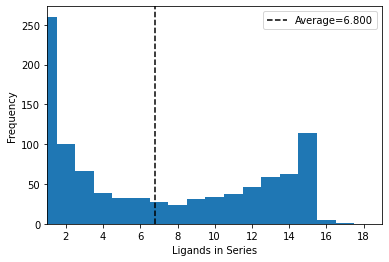

In [9]:
ic50_rm_lig_gp = ic50_avail_df.groupby('Receptor')
lig_counts = ic50_rm_lig_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [10]:
more_than_one_IC50_bool = ic50_avail_df['IC50(nM)'].apply(lambda x: len(str(x).split(';')) > 1)
ic50_rm_mt1_meas = ic50_avail_df[~more_than_one_IC50_bool].copy()
ic50_rm_mt1_meas['IC50(nM)'] = ic50_rm_mt1_meas['IC50(nM)'].apply(lambda x: float(x.strip('><')) if isinstance(x,str) else x)
ic50_mt1_meas = (ic50_avail_df[more_than_one_IC50_bool].reset_index())



In [11]:
## Getting the median of the ligands with more than 1 measurement if the measurements are all within 1 order
## of magnitude, otherwise just throwing them out (for now)
ic50_mt1_meas['all IC50s'] = ic50_mt1_meas['IC50(nM)']
ic50_mt1_meas['IC50 mag range'] = ic50_mt1_meas['all IC50s'].apply(get_range_magnitude)
ic50_mt1_good = ic50_mt1_meas[ic50_mt1_meas['IC50 mag range'] < 1].copy()
ic50_mt1_good['IC50(nM)'] = ic50_mt1_good['all IC50s'].apply(lambda x: np.median([float(val.strip('><')) for val in x.split(';')]))

In [12]:
all_ic50_meas = ic50_rm_mt1_meas.append(ic50_mt1_good).reset_index()
all_ic50_gp = all_ic50_meas.groupby('rec_ligscaff')
all_ic50_final = all_ic50_gp.filter(lambda x: len(x['Ligand ID'].unique()) > 1) ## remove groups with less than 2 ligands

In [13]:
print(f"{(ic50_mt1_meas['IC50 mag range'] > 1).sum()} out of {ic50_mt1_meas.shape[0]} have a range greater than 1 magnitude")

325 out of 822 have a range greater than 1 magnitude


Text(0.5, 0, 'pIC50')

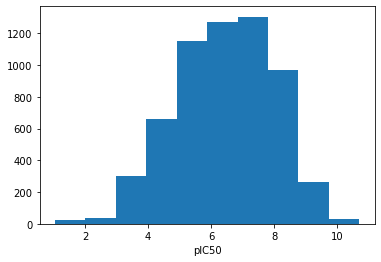

In [14]:
plt.hist(-np.log10(all_ic50_final['IC50(nM)']*(1E-9)))
plt.xlabel('pIC50')

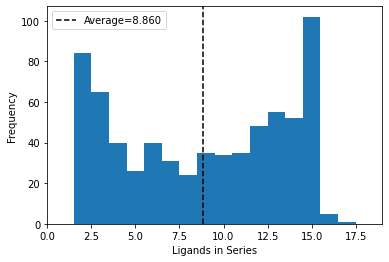

In [15]:
ic50_rm_lig_gp = all_ic50_final.groupby('Receptor')
lig_counts = ic50_rm_lig_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([0,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

## Looking at overlap with Jimenez-Luna

In [16]:
import pickle
from rdkit.Chem import rdFMCS

In [17]:
prot_dist, target_lig_pair, lig_sim = pickle.load(open('../fullbdb_external_simi.pickle', 'rb'))
ic50_jl_comp = all_ic50_final.copy()
ic50_jl_comp['lig file'] = ic50_jl_comp['Structure File'].apply(lambda x: 'ddg_dataset/' + '/'.join(x.split('/')[-2:]))
ic50_jl_comp['mol'] = ic50_jl_comp['lig file'].apply(lambda x: Chem.MolFromMol2File(x,sanitize=False))
# ic50_jl_comp['fing'] = ic50_jl_comp['mol'].apply(lambda x: Chem.RDKFingerprint(x))

In [18]:
internal_pairs = target_lig_pair[:8858]
internal_targets = [pair.split('_')[0] for pair in internal_pairs]
print(len(internal_pairs))
internal_pdist = prot_dist[:8858,:8858]
print(internal_pdist.shape)
simi_idxs = np.array((internal_pdist[0,:] <= 0.1) ^ (pd.Series(internal_targets) == internal_targets[0])).nonzero()[0]
same_prot = np.flatnonzero(pd.Series(internal_targets) == internal_targets[0])
internal_lsim = lig_sim[:8858,:8858]
first_series = internal_lsim[same_prot]

8858
(8858, 8858)


In [19]:
all_ligs = pd.read_csv('../all_ligs.txt',sep=' ',header=None)
all_ligs.drop_duplicates(subset=0,inplace=True)
all_ligs.sort_values(1,ascending=False,inplace=True)
mapping = all_ligs[:8858].copy()
mapping.sort_values(0,inplace=True)
mapping.reset_index(drop=True)
mapping.columns = ['name','rec','lig']
mapping['mol'] = mapping.lig.apply(lambda x: Chem.MolFromSmiles(open('/'.join(x.split('/')[1:]),'r').read()))
mapping['df idx array'] = mapping['lig'].apply(lambda x: ic50_jl_comp[ic50_jl_comp['lig file'] == ('/'.join(x.split('/')[1:])).replace('.smi','.mol2')].index.array)
mapping['df idx'] = mapping['df idx array'].apply(lambda x: '' if len(x) == 0 else int(x[0]))
map_to_idx = mapping['df idx'].to_dict()

RDKit ERROR: [17:22:18] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 15 16 17 28 29 30
RDKit ERROR: 
RDKit ERROR: [17:22:18] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 15 16 17 27 28 29
RDKit ERROR: 
RDKit ERROR: [17:22:18] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 15 16 17 28 29 30
RDKit ERROR: 
RDKit ERROR: [17:22:18] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 14 15 16 26 27 28
RDKit ERROR: 
RDKit ERROR: [17:22:18] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 21 22 23
RDKit ERROR: 
RDKit ERROR: [17:22:18] Can't kekulize mol.  Unkekulized atoms: 0 1 2 12 13 14 15 16 17 18 27
RDKit ERROR: 
RDKit ERROR: [17:22:18] Can't kekulize mol.  Unkekulized atoms: 0 1 2 12 13 14 15 16 17 18 32
RDKit ERROR: 
RDKit ERROR: [17:22:20] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 16 17 18 21 24 25
RDKit ERROR: 
RDKit ERROR: [17:22:20] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 16 17 18 21 24 25
RDKit ERROR: 
RDKit ERROR: [17:2

(array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
        5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9]),
 array([ 4, 22, 33, 48,  1, 18, 37, 42,  3, 17, 28, 45,  0, 24, 35, 39, 13,
        25, 34, 38,  7, 19, 31, 46,  2, 14, 30, 47, 12, 20, 27, 41,  9, 21,
        29, 44,  5, 23, 26, 43]))

In [20]:
looked_at = set()
duplicate_pairs= []
for i in range(len(internal_targets)):
    if internal_targets[i] in looked_at:
        continue
    else:
        looked_at.add(internal_targets[i])
    simi_idxs = np.array((internal_pdist[i,:] <= 0.1) ^ (pd.Series(internal_targets) == internal_targets[i])).nonzero()[0]
    for si in simi_idxs:
        looked_at.add(internal_targets[si])
    same_prot = np.flatnonzero(pd.Series(internal_targets) == internal_targets[i])

    cong_series = internal_lsim[same_prot,:]
    first_ind, second_ind = np.nonzero(cong_series[:,simi_idxs] > 0.95)
    print(i,len(first_ind))
    for idx1, idx2 in zip(first_ind,second_ind):
        idx1 = same_prot[idx1]
        idx2 = simi_idxs[idx2]
        if idx1 == idx2:
            continue
        if map_to_idx[idx2] == '' or map_to_idx[idx1] == '': #not in IC50 measures
            continue
        mol1 = mapping.iloc[idx1]['mol']
        mol2 = mapping.iloc[idx2]['mol']
        if mol1 is None:
            mol1 = Chem.MolFromSmiles(open('/'.join(mapping.iloc[idx1]['lig'].split('/')[1:])).read(),sanitize=False)
        if mol2 is None:
            mol2 = Chem.MolFromSmiles(open('/'.join(mapping.iloc[idx2]['lig'].split('/')[1:])).read(),sanitize=False)
        result = rdFMCS.FindMCS([mol1,mol2])
        intersect,a1,a2 = result.numAtoms,mol1.GetNumAtoms(),mol2.GetNumAtoms()
        if intersect==a1 and intersect==a2:
           duplicate_pairs.append((idx1,idx2)) 

0 92
10 4
12 0
24 4
26 2
43 6
46 0
56 0
58 89
159 0
161 0
165 13
175 9
181 0
190 0
206 15
213 0
215 4
219 0
223 0
240 0
251 12
255 116
270 0
284 4
334 73
375 6
379 0
453 0
466 0
470 12
480 5
483 1
495 1
594 0
596 7
607 0
620 105
632 0
646 0
650 0
675 2
677 268
691 0
698 11
815 34
829 2
836 0
867 0
871 7
879 2
896 1
909 8
921 60
970 21
992 0
1042 2
1092 0
1159 5
1210 3
1213 0
1272 50
1304 27
1355 8
1389 27
1427 0
1441 0
1453 0
1460 13
1471 0
1474 0
1492 0
1505 12
1533 0
1538 208
1565 0
1595 6
1615 10
1637 0
1651 42
1704 5
1711 0
1737 0
1791 0
1802 0
1818 0
1847 0
1862 10
1881 0
1888 2
1892 0
1902 0
1962 0
1965 0
2080 0
2127 0
2130 0
2174 14
2219 0
2392 0
2404 0
2429 66
2706 0
2814 0
2828 1
2879 0
2899 0
2914 0
2922 5
2978 2
2980 0
3089 52
3127 29
3243 0
3247 4
3253 0
3278 0
3293 0
3339 23
3442 0
3447 0
3473 0
3486 15
3519 1
3521 0
3524 8
3636 0
3649 0
3660 0
3675 202
3700 0
3729 0
3740 0
3878 3
3895 13
3928 0
3943 0
3958 0
4000 0
4076 11
4148 4
4182 0
4197 0
4212 5
4247 0
4454 0
4493 0


In [29]:
originals, duplicates = [],[]
for o,d in duplicate_pairs:
    originals.append(o)
    duplicates.append(d)
print(set(originals).intersection(set(duplicates)))
print(len(duplicates),len(set(duplicates)))

set()
1208 1056
1208 490


In [69]:
deduplicates = list(set(duplicates))
mapped_dups = [map_to_idx[d] for d in deduplicates if (d in map_to_idx.keys()) and (map_to_idx[d] != '')]

In [75]:
ic50_jl_fin = ic50_jl_comp.drop(index=mapped_dups).copy()
ic50_jl_gp =  ic50_jl_fin.groupby('rec_ligscaff')
ic50_jl_final = ic50_jl_gp.filter(lambda x: len(x['Ligand ID'].unique()) > 1) ## remove groups with less than 2 ligands
receptors = set()
cong_series=set()
comparisons=0
ligands_per_series = []
range_of_series = []
dg_values = []
ms_df = ic50_jl_final
measurement = 'IC50(nM)'
receptors = receptors.union(set(ms_df['Receptor'].unique().tolist()))
ligands_per_series += ms_df.groupby('rec_ligscaff')['Ligand ID'].count().tolist()
dg_values += (-np.log10(ms_df[measurement]*1E-9)).tolist()
range_of_series += (-np.log10(ms_df.groupby('rec_ligscaff')[measurement].min().values*1E-9)+np.log10(ms_df.groupby('rec_ligscaff')[measurement].max().values*1E-9)).tolist()
cong_series = cong_series.union(set([f"{val}_{measurement}" for val in ms_df['rec_ligscaff'].unique().tolist()]))
comparisons += ms_df.groupby('rec_ligscaff')['Structure File'].count().apply(lambda x: math.factorial(x)/math.factorial(x-2) if x>=2 else 0).sum()
print(len(receptors),len(cong_series))

639 639


In [84]:
ic50_jl_final.to_csv('jimenez/jl_comparison_set.csv',columns=['Receptor','Ligand ID','rec_ligscaff','lig file','IC50(nM)'],index=False)

6.411203077071128


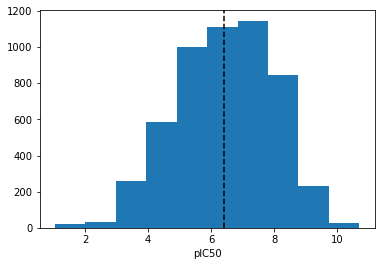

In [89]:
plt.hist(-np.log10(ic50_jl_final['IC50(nM)']*(1E-9)))
plt.axvline(np.mean(-np.log10(ic50_jl_final['IC50(nM)']*(1E-9))),color='k',ls='--')
plt.xlabel('pIC50')
print(np.mean(-np.log10(ic50_jl_final['IC50(nM)']*(1E-9))))

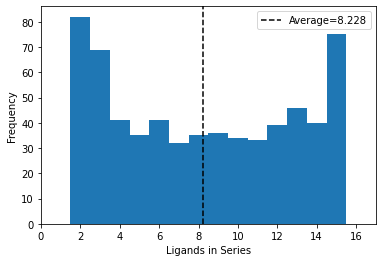

In [90]:
ic50_rm_lig_gp =ic50_jl_final.groupby('Receptor')
lig_counts = ic50_rm_lig_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([0,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [91]:
meas_dfs = [(ic50_jl_final,'IC50(nM)')]

### Ki is next most prevalent
Therefore we subset the whole frame to those ligands with Ki measurements

In [16]:
ki_avail_df = full_docked_df[full_docked_df['Ki(nM)'].notna()]

In [17]:
print('{} unique receptors'.format(len(ki_avail_df['Receptor'].unique())))
print('{} unique recptor-ligand pairs'.format(len(ki_avail_df.drop_duplicates(subset=['Receptor','Ligand ID']))))

474 unique receptors
2415 unique recptor-ligand pairs


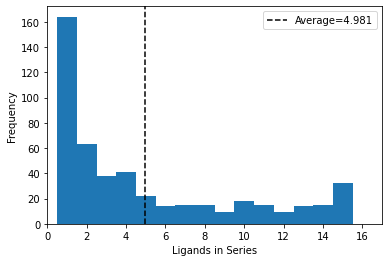

In [18]:
ki_avail_df_gp = ki_avail_df.groupby('rec_ligscaff')
lig_counts = ki_avail_df_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([0,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [19]:
# ki_mt1_meas = ki_rm_lig['Ki(nM)'].apply(lambda x: np.median([float(val.strip('><')) for val in x.split(';')] if isinstance(x,str) else x ))
more_than_one_KI_bool = ki_avail_df['Ki(nM)'].apply(lambda x: len(str(x).split(';')) > 1)
ki_rm_mt1_meas = ki_avail_df[~more_than_one_KI_bool].copy()
ki_rm_mt1_meas['Ki(nM)'] = ki_rm_mt1_meas['Ki(nM)'].apply(lambda x: float(x.strip('><')) if isinstance(x,str) else x)
ki_mt1_meas = (ki_avail_df[more_than_one_KI_bool].reset_index())

In [20]:
## Getting the median of the ligands with more than 1 measurement if the measurements are all within 1 order
## of magnitude, otherwise just throwing them out (for now)
ki_mt1_meas['all Kis'] = ki_mt1_meas['Ki(nM)']
ki_mt1_meas['Ki mag range'] = ki_mt1_meas['all Kis'].apply(get_range_magnitude)
ki_mt1_good = ki_mt1_meas[ki_mt1_meas['Ki mag range'] < 1].copy()
ki_mt1_good['Ki(nM)'] = ki_mt1_good['all Kis'].apply(lambda x: np.median([float(val.strip('><')) for val in x.split(';')]))

In [21]:
print(f"{(ki_mt1_meas['Ki mag range'] > 1).sum()} out of {ki_mt1_meas.shape[0]} have a range greater than 1 magnitude")

115 out of 326 have a range greater than 1 magnitude


In [22]:
all_ki_meas = ki_rm_mt1_meas.append(ki_mt1_good).reset_index()
all_ki_meas = all_ki_meas.drop(all_ki_meas[all_ki_meas['Ki(nM)'] == 0].index)
all_ki_gp = all_ki_meas.groupby('rec_ligscaff')
all_ki_final = all_ki_gp.filter(lambda x: len(x['Ligand ID'].unique()) > 1) ## remove groups with less than 2 ligands

In [23]:
# Manually fixing some entries that are wrong
# Taken from 'QSAR study on topically acting sulfonamides incorporating GABA moieties: A molecular connectivity approach' 
all_ki_final.loc[all_ki_meas[(all_ki_meas['Ligand ID'] == '10882')].index,'Ki(nM)'] = np.exp(-0.9543)/(1E-9)

Text(0.5, 0, 'pKi')

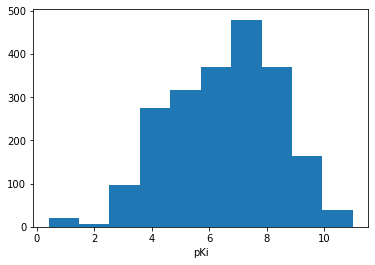

In [24]:
plt.hist(-np.log10(all_ki_final['Ki(nM)']*(1E-9)))
plt.xlabel('pKi')

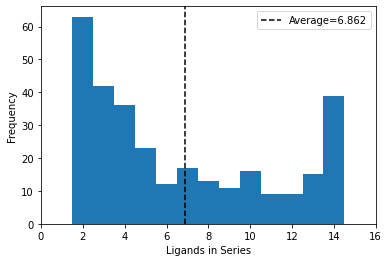

In [25]:
ki_avail_df_gp = all_ki_final.groupby('rec_ligscaff')
lig_counts = ki_avail_df_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([0,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

### Kd is the least prevalent
Therefore we subset the whole frame to those ligands with Kd measurements

In [26]:
kd_avail_df = full_docked_df[full_docked_df['Kd(nM)'].notna()]

In [27]:
print('{} unique receptors'.format(len(kd_avail_df['Receptor'].unique())))
print('{} unique recptor-ligand pairs'.format(len(kd_avail_df.drop_duplicates(subset=['Receptor','Ligand ID']))))

218 unique receptors
662 unique recptor-ligand pairs


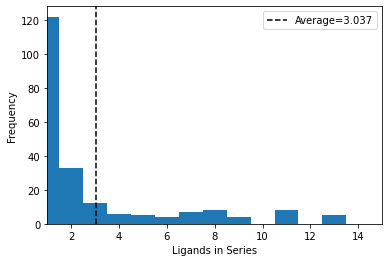

In [28]:
kd_rm_lig_gp = kd_avail_df.groupby('rec_ligscaff')
lig_counts = kd_rm_lig_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [29]:
more_than_one_KD_bool = kd_avail_df['Kd(nM)'].apply(lambda x: len(str(x).split(';')) > 1)
kd_rm_mt1_meas = kd_avail_df[~more_than_one_KD_bool].copy()
kd_rm_mt1_meas['Kd(nM)'] = kd_rm_mt1_meas['Kd(nM)'].apply(lambda x: float(x.strip('><')) if isinstance(x,str) else x)
kd_mt1_meas = (kd_avail_df[more_than_one_KD_bool].reset_index())

In [30]:
## Getting the median of the ligands with more than 1 measurement if the measurements are all within 1 order
## of magnitude, otherwise just throwing them out (for now)
kd_mt1_meas['all Kds'] = kd_mt1_meas['Kd(nM)']
kd_mt1_meas['Kd mag range'] = kd_mt1_meas['all Kds'].apply(get_range_magnitude)
kd_mt1_good = kd_mt1_meas[kd_mt1_meas['Kd mag range'] < 1].copy()
kd_mt1_good['Kd(nM)'] = kd_mt1_good['all Kds'].apply(lambda x: np.median([float(val.strip('><')) for val in x.split(';')]))

In [31]:
print(f"{(kd_mt1_meas['Kd mag range'] > 1).sum()} out of {kd_mt1_meas.shape[0]} have a range greater than 1 magnitude")

36 out of 206 have a range greater than 1 magnitude


In [32]:
all_kd_meas = kd_rm_mt1_meas.append(kd_mt1_good).reset_index()
all_kd_meas = all_kd_meas.drop(all_kd_meas[all_kd_meas['Kd(nM)'] == 0].index)
all_kd_gp = all_kd_meas.groupby('rec_ligscaff')
all_kd_final = all_kd_gp.filter(lambda x: len(x['Ligand ID'].unique()) > 1) ## remove groups with less than 2 ligands


In [33]:
print(min(-np.log10(all_kd_meas['Kd(nM)']*(1E-9))),max(-np.log10(all_kd_meas['Kd(nM)']*(1E-9))))

1.6882461389442456 11.0


Text(0.5, 0, 'pKd')

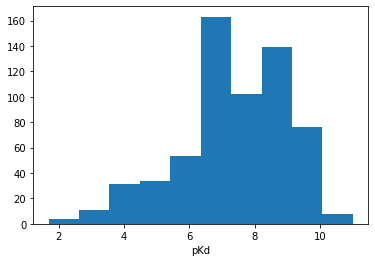

In [34]:
plt.hist(-np.log10(all_kd_meas['Kd(nM)']*(1E-9)))
plt.xlabel('pKd')

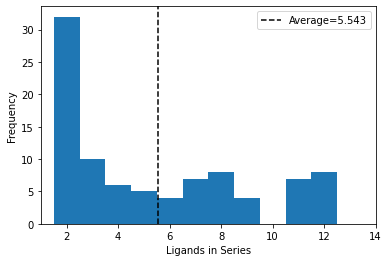

In [35]:
kd_rm_lig_gp = all_kd_final.groupby('rec_ligscaff')
lig_counts = kd_rm_lig_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [36]:
## SEtting up the list of dataframes/measurments
meas_dfs= [(all_ic50_final,'IC50(nM)'),(all_ki_final,'Ki(nM)'),(all_kd_final,'Kd(nM)')]

## What about Receptors:
Only including receptors that have more than 1 ligand

In [51]:
meas_r_list = []
for df,meas in meas_dfs:
    meas_r_list.append(df['Receptor'].nunique())
#     print(f'Non-Nan {meas}:{meas_r_list[-1]}')

Text(0.5, -0.5, 'Covers 943 unique PDB IDs')

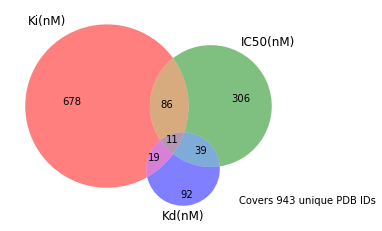

In [52]:
meas_recs = dict()
for df,meas in meas_dfs:
    meas_recs[meas]=set(df[df[meas].notna()].apply(lambda row: '{}'.format(row['Receptor']), axis=1).values.tolist())
total_overlap = len(meas_recs['Ki(nM)'].intersection(meas_recs['IC50(nM)'],meas_recs['Kd(nM)']))
ki_ic50_overlap = len(meas_recs['Ki(nM)'].intersection(meas_recs['IC50(nM)']))
ki_kd_overlap = len(meas_recs['Ki(nM)'].intersection(meas_recs['Kd(nM)']))
ic50_kd_overlap = len(meas_recs['Kd(nM)'].intersection(meas_recs['IC50(nM)']))

venn3(subsets = (meas_r_list[0], meas_r_list[1], ki_ic50_overlap, meas_r_list[2], ki_kd_overlap, ic50_kd_overlap, total_overlap), set_labels = ('Ki(nM)', 'IC50(nM)','Kd(nM)'), alpha = 0.5)
plt.annotate(f"Covers {len(meas_recs['Ki(nM)'].union(meas_recs['IC50(nM)'],meas_recs['Kd(nM)']))} unique PDB IDs",xy=(0.5,-0.5))

### Number of Ligands with each type of Measurement
Again only considering ligands of proteins that have more than 1 ligand associated

In [53]:
meas_list = []
for df,meas in meas_dfs:
    meas_list.append(len(df.drop_duplicates(subset=['Receptor','Ligand ID'])))
#     print(f'Non-Nan {meas}:{meas_list[-1]}')

Text(0.5, -0.5, 'Covers 8452 protein-ligand pairs')

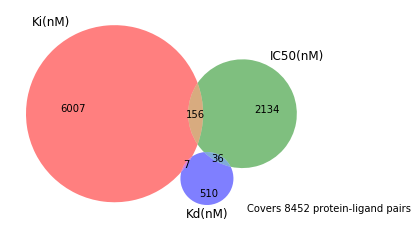

In [54]:
meas_ligs = dict()
for df,meas in meas_dfs:
    meas_ligs[meas]=set(df.apply(lambda row: '{}_{}'.format(row['Receptor'],row['Ligand ID']), axis=1).values.tolist())
total_overlap = len(meas_ligs['Ki(nM)'].intersection(meas_ligs['IC50(nM)'],meas_ligs['Kd(nM)']))
ki_ic50_overlap = len(meas_ligs['Ki(nM)'].intersection(meas_ligs['IC50(nM)']))
ki_kd_overlap = len(meas_ligs['Ki(nM)'].intersection(meas_ligs['Kd(nM)']))
ic50_kd_overlap = len(meas_ligs['Kd(nM)'].intersection(meas_ligs['IC50(nM)']))

venn3(subsets = (meas_list[0], meas_list[1], ki_ic50_overlap, meas_list[2], ki_kd_overlap, ic50_kd_overlap, total_overlap), set_labels = ('Ki(nM)', 'IC50(nM)','Kd(nM)'), alpha = 0.5)
plt.annotate(f"Covers {len(meas_ligs['Ki(nM)'].union(meas_ligs['IC50(nM)'],meas_ligs['Kd(nM)']))} protein-ligand pairs",xy=(0.5,-0.5))

### Number of Congeneric Series with each type of Measurement
Again only considering ligands of proteins that have more than 1 ligand associated

In [55]:
meas_s_list = []
for df,meas in meas_dfs:
    meas_s_list.append(df['rec_ligscaff'].nunique())
#     print(f'Non-Nan {meas}:{meas_list[-1]}')

Text(0.5, -0.5, 'Covers 949 congeneric series')

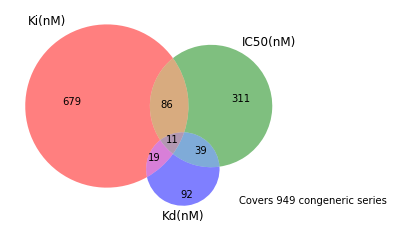

In [56]:
meas_series = dict()
for df,meas in meas_dfs:
    meas_series[meas]=set(df[df[meas].notna()].apply(lambda row: '{}'.format(row['rec_ligscaff']), axis=1).values.tolist())
total_overlap = len(meas_series['Ki(nM)'].intersection(meas_series['IC50(nM)'],meas_series['Kd(nM)']))
ki_ic50_overlap = len(meas_series['Ki(nM)'].intersection(meas_series['IC50(nM)']))
ki_kd_overlap = len(meas_series['Ki(nM)'].intersection(meas_series['Kd(nM)']))
ic50_kd_overlap = len(meas_series['Kd(nM)'].intersection(meas_series['IC50(nM)']))

venn3(subsets = (meas_s_list[0], meas_s_list[1], ki_ic50_overlap, meas_s_list[2], ki_kd_overlap, ic50_kd_overlap, total_overlap), set_labels = ('Ki(nM)', 'IC50(nM)','Kd(nM)'), alpha = 0.5)
plt.annotate(f"Covers {len(meas_series['Ki(nM)'].union(meas_series['IC50(nM)'],meas_series['Kd(nM)']))} congeneric series",xy=(0.5,-0.5))

In [57]:
sum(meas_s_list)

1082

# Dealing with values with more than 1 IC50 measurement
If we just toss them all out:

In [ ]:
more_than_one_IC50_bool = ic50_rm_lig['IC50(nM)'].apply(lambda x: len(str(x).split(';')) > 1)
ic50_rm_lig['IC50(nM)'] = ic50_rm_lig['IC50(nM)'].apply(lambda x: x.strip('><') if type(x) is str else x)
ic50_rm_mt1_meas = ic50_rm_lig[~more_than_one_IC50_bool].copy()
ic50_rm_mt1_meas['IC50(nM)'] = ic50_rm_mt1_meas['IC50(nM)'].astype(float)
ic50_rm_mt1_meas_gp = ic50_rm_mt1_meas.groupby('Receptor')
ic50_rm_lig_and_mt1 = ic50_rm_mt1_meas_gp.filter(lambda x: len(x) > 1) ## remove groups with less than 2 ligands
print('{} unique PDBIDs with greater than 1 ligand'.format(len(ic50_rm_lig_and_mt1['Receptor'].unique())))
print('{} unique receptor-ligand pairs'.format(len(ic50_rm_lig_and_mt1.drop_duplicates(subset=['Receptor','Ligand ID']))))

In [ ]:
print(f'{more_than_one_IC50_bool.sum()} ligands with multiple IC50 values')

In [ ]:
ic50_fin_gp = ic50_rm_lig_and_mt1.groupby('Receptor')
lig_counts = ic50_fin_gp.count()['Ligand ID']
plt.hist(lig_counts,bins=np.arange(1,max(lig_counts),1),align='left')
plt.axvline(x=np.mean(lig_counts),label=f'Average={np.mean(lig_counts):.3f}',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1.5,max(lig_counts)])
plt.ylabel('Frequency')
plt.legend()

In [ ]:
ic50_range = -np.log10(ic50_fin_gp['IC50(nM)'].max()*(1E-9)) + np.log(ic50_fin_gp['IC50(nM)'].min()*(1E-9))
plt.hist(ic50_range,align='left')
plt.axvline(x=np.mean(ic50_range),label=f'Average={np.mean(ic50_range):.3f}',color='k',linestyle='--')
plt.xlabel('$pIC_{50}$ Range in Each Congeneric Series (nM)')
plt.xlim([1.5,max(ic50_range)])
plt.ylabel('Frequency')
plt.legend()

In [ ]:
import matplotlib.colors as mcolors 
ic50_mt1_meas = (ic50_rm_lig[more_than_one_IC50_bool].reset_index())
ic50_mt1_meas['split IC50(nM)'] = ic50_mt1_meas['IC50(nM)'].apply(lambda x: [float(val.strip('><')) for val in x.split(';')])
fig = plt.figure(figsize=[15,8])
colors = list(mcolors.BASE_COLORS.keys())
sum_range = 0
val_ranges = []
for idx, row in ic50_mt1_meas.iterrows():
    c = colors[idx % len(colors)]
    val_range=max(row['split IC50(nM)'])-min(row['split IC50(nM)'])
    plt.bar(idx,val_range,color=c)
    val_ranges.append(val_range)
    sum_range+= val_range
plt.hlines(sum_range/idx,0,idx,linestyles='--')
plt.annotate(f'{sum_range/idx:.2f}',(idx,sum_range/idx))
plt.ylabel('Range of $IC_{50}$ values (nM)')

In [ ]:
plt.hist([vals for vals in val_ranges if vals < 1E3 ],bins=100)

In [ ]:
len(val_ranges)

In [ ]:
for num in range(1,9):
    print(f'{len([vals for vals in val_ranges if vals < 1*10**(num)])}')

In [ ]:
sum_lens = 0
number_vals = [len(list_vals) for list_vals in ic50_mt1_meas['split IC50(nM)'].values.tolist()]
print(f'Avg Number of IC50 vals:{np.mean(number_vals)}\nMedian number:\t\t{np.median(number_vals)}\nMaximum number:\t\t{max(number_vals)}')
plt.hist(number_vals)
plt.xlabel('Number of $IC_{50}$ measurements for a protein-ligand pair')
plt.ylabel('Number of protein-ligand pairs')

# Setting up the dataset

In [37]:
receptors = set()
cong_series=set()
comparisons=0
ligands_per_series = []
range_of_series = []
dg_values = []
for ms_df,measurement in meas_dfs:
    receptors = receptors.union(set(ms_df['Receptor'].unique().tolist()))
    ligands_per_series += ms_df.groupby('rec_ligscaff')['Ligand ID'].count().tolist()
    dg_values += (-np.log10(ms_df[measurement]*1E-9)).tolist()
    range_of_series += (-np.log10(ms_df.groupby('rec_ligscaff')[measurement].min().values*1E-9)+np.log10(ms_df.groupby('rec_ligscaff')[measurement].max().values*1E-9)).tolist()
    cong_series = cong_series.union(set([f"{val}_{measurement}" for val in ms_df['rec_ligscaff'].unique().tolist()]))
    comparisons += ms_df.groupby('rec_ligscaff')['Structure File'].count().apply(lambda x: math.factorial(x)/math.factorial(x-2) if x>=2 else 0).sum()

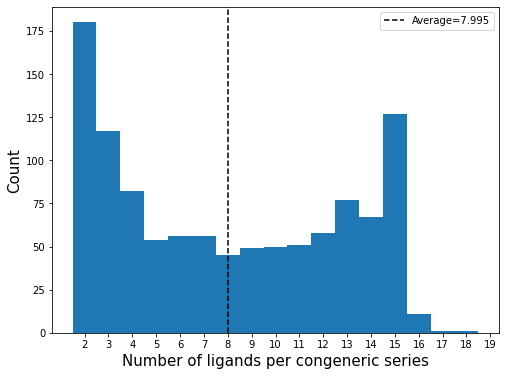

In [38]:
plt.figure(figsize=[8,6])
plt.hist(ligands_per_series,bins=np.arange(min(ligands_per_series), max(ligands_per_series) + 1, 1),align='left')
plt.xticks(np.arange(min(ligands_per_series), max(ligands_per_series) + 1, 1))
plt.xlabel('Number of ligands per congeneric series',size=15)
plt.ylabel('Count',size=15)
plt.axvline(x=np.mean(ligands_per_series),label=f'Average={np.mean(ligands_per_series):.3f}',color='k',linestyle='--')
plt.legend()
# plt.savefig('congeneric_series_counts.png',dpi=300,transparent=True)
plt.savefig('../figs/congeneric_series_counts.pdf')

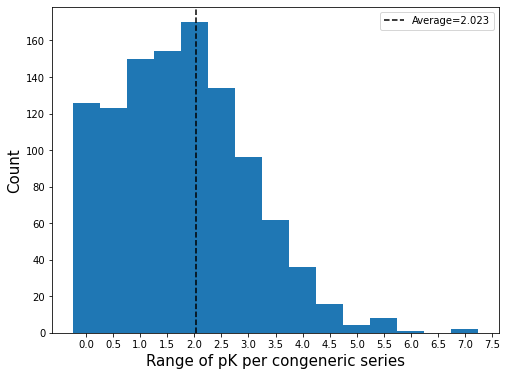

In [39]:
plt.figure(figsize=[8,6])
plt.hist(range_of_series,bins=np.arange(min(range_of_series), max(range_of_series) + 0.5, 0.5),align='left')
plt.xticks(np.arange(min(range_of_series), max(range_of_series) + 0.5, 0.5))
plt.xlabel('Range of pK per congeneric series',size=15)
plt.ylabel('Count',size=15)
plt.axvline(x=np.mean(range_of_series),label=f'Average={np.mean(range_of_series):.3f}',color='k',linestyle='--')
plt.legend()
# plt.savefig('congeneric_series_range.png',dpi=300,transparent=True)
plt.savefig('../figs/congeneric_series_range.pdf')

In [40]:
print(np.mean(dg_values),np.var(dg_values))

6.49689242681033 2.787899842367767


In [41]:
# Making sure there are no values that are less than 0
print(np.array(dg_values)[np.where(np.array(dg_values)<0)])

[]


In [42]:
print(len(receptors),len(cong_series),comparisons)

943 1082 85102.0


In [43]:
# This was run to ensure the correct files were in the correct places, should not need to be ran again
## copy over the receptor file and ligand file
# bad_files = []
# for ms_df,measurement in meas_dfs:
#     ms_df['Reference'] = 0
#     ms_df['local file'] = ''
#     for recdir, group in ms_df.groupby('rec_ligscaff'):
#         max_tan = 0
#         sf = None
#         if not os.path.isdir(f"ddg_dataset/{recdir}"):
#             os.mkdir(f"ddg_dataset/{recdir}")
#         shutil.copyfile(f"BDB_docked/{recdir}/{recdir.split('_')[0]}.mol2",f"ddg_dataset/{recdir}/{recdir.split('_')[0]}.mol2")
#         refmol = Chem.MolFromMolFile(f"BDB_docked/{recdir}/{recdir.split('_')[1]}.sdf",sanitize=False)
#         if refmol is None:
#             print(recdir)
#             (obabel[f"BDB_docked/{recdir}/{recdir.split('_')[1]}.sdf","-O",f"BDB_docked/{recdir}/{recdir.split('_')[1]}_ob.sdf"])()
#             refmol = Chem.MolFromMol2File(f"BDB_docked/{recdir}/{recdir.split('_')[1]}_ob.sdf",sanitize=False)
#         ref_fp = Chem.RDKFingerprint(refmol)
#         for idx, row in group.iterrows():
#             filename = row['Structure File'].split('/')[-1]
#             if os.path.isfile(f"BDB_docked/{recdir}/{filename}"):
#                 shutil.copyfile(f"BDB_docked/{recdir}/{filename}",f"ddg_dataset/{recdir}/{filename}")
#             else:
#                 print(f"BDB_docked/{recdir}/{filename}")
#                 bad_files.append(row['Structure File'])
#             compmol = Chem.MolFromMol2File(f"ddg_dataset/{recdir}/{filename}",sanitize=False)
#             comp_fp = Chem.RDKFingerprint(compmol)
#             Tan = DataStructs.TanimotoSimilarity(ref_fp,comp_fp)
#             if Tan > max_tan: ## assigning the reference to the molecule with the highest Tanimoto Sim to the molecule used in the fragment docking
#                 max_tan = Tan
#                 sf = row['Structure File']
# #         print(max_tan,ref_idx)
#         ms_df.loc[ms_df['Structure File'] == sf,'Reference'] = 1

In [44]:
## Don't need to run this if you have already run the last cell
bad_files = []
for ms_df,measurement in meas_dfs:
    ms_df['Reference'] = 0
    ms_df['local file'] = ''
    for recdir, group in ms_df.groupby('rec_ligscaff'):
        max_tan = 0
        sf = None
        refmol = Chem.MolFromMolFile(f"BDB_docked/{recdir}/{recdir.split('_')[1]}.sdf",sanitize=False)
        if refmol is None:
            print(recdir)
            (obabel[f"BDB_docked/{recdir}/{recdir.split('_')[1]}.sdf","-O",f"BDB_docked/{recdir}/{recdir.split('_')[1]}_ob.sdf"])()
            refmol = Chem.MolFromMol2File(f"BDB_docked/{recdir}/{recdir.split('_')[1]}_ob.sdf",sanitize=False)
        ref_fp = Chem.RDKFingerprint(refmol)
        for idx, row in group.iterrows():
            filename = row['Structure File'].split('/')[-1]
            compmol = Chem.MolFromMol2File(f"ddg_dataset/{recdir}/{filename}",sanitize=False)
            comp_fp = Chem.RDKFingerprint(compmol)
            Tan = DataStructs.TanimotoSimilarity(ref_fp,comp_fp)
            if Tan > max_tan: ## assigning the reference to the molecule with the highest Tanimoto Sim to the molecule used in the fragment docking
                max_tan = Tan
                sf = row['Structure File']
#         print(max_tan,ref_idx)
        ms_df.loc[ms_df['Structure File'] == sf,'Reference'] = 1

RDKit WARNING: [15:47:15] BindingDB_26991: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [15:47:15] BindingDB_50278322: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [15:47:15] BindingDB_26991: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [15:47:15] BindingDB_50278322: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [15:47:15] BindingDB_26991: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [15:47:15] BindingDB_50278322: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [15:47:15] BindingDB_26992: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [15:47:15] BindingDB_26991: Warning - no explicit hydrogens in mol2 file 

No bad files!

In [45]:
ms_df

,level_0,Compound,Structure File,Surflex Score,Ki(nM),IC50(nM),Kd(nM),Receptor,Ligand ID,rec_ligscaff,index,all Kds,Kd mag range,Reference,local file
0,0,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/data/surflex/4ABV_FT2...,0.8705,NaN,NaN,144000.0,4ABV,8726,4ABV_FT2,NaN,NaN,NaN,1,
1,1,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/data/surflex/4ABV_FT2...,2.4598,NaN,1360,0.3,4ABV,50225216,4ABV_FT2,NaN,NaN,NaN,0,
2,3,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/data/surflex/4ABV_FT2...,2.3189,NaN,1310,88.0,4ABV,50225219,4ABV_FT2,NaN,NaN,NaN,0,
3,4,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/data/surflex/4ABV_FT2...,1.5354,NaN,520,14.0,4ABV,50225224,4ABV_FT2,NaN,NaN,NaN,0,
4,6,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/data/surflex/4ABV_FT2...,0.4257,NaN,NaN,0.2,4ABV,50225226,4ABV_FT2,NaN,NaN,NaN,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,198,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/data/surflex/3MHL_J71...,5.6475,NaN,NaN,33.5,3MHL,50329764,3MHL_J71,8816.0,24;43,0.253257,0,
620,199,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/data/surflex/3MHL_J71...,6.6708,NaN,NaN,53.0,3MHL,50329770,3MHL_J71,8820.0,50;56,0.049218,1,
621,200,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/data/surflex/3MHL_J71...,5.1871,NaN,NaN,110.0,3MHL,50329771,3MHL_J71,8821.0,70;150,0.330993,0,
624,204,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/data/surflex/2NNO_M28...,4.0219,125;125000;110;2;50;500034535;9090756;10997652...,NaN,410300.0,2NNO,10877,2NNO_M28,9301.0,392000;428600,0.038766,0,


In [57]:
# Output txt files
for ms_df,meas in meas_dfs:
    ms_df.to_csv(f'fullbdb_{meas}.txt',sep=',',columns=['Structure File',f'{meas}','Receptor','Ligand ID','rec_ligscaff','Reference'])

In [2]:
# Read in txt files
meas_dfs = []
for file in glob('fullbdb_*.txt'):
    meas_dfs.append((pd.read_csv(file),file.split('.')[0].split('_')[-1]))

In [46]:
# prepare the dataframes for making train/test types files
for ms_df,measurement in meas_dfs:
    ms_df.reset_index(drop=True,inplace=True)
    ms_df['fname'] = ms_df['Structure File'].apply(lambda x: x.split('/')[-1])
    ms_df['pK'] = ms_df[measurement].apply(lambda x: -np.log10(x*(1E-9)) )
    ms_df['ligloc'] = ms_df.apply(lambda x: f"{x['rec_ligscaff']}/{x['fname'].split('.')[0]}_0.gninatypes",axis=1)

In [61]:
# randos=[0,1,2,3,4]
trainfile_bname = 'all_train_triplet'
testfile_bname = 'all_test_triplet'

def check_bad(num):
    if num == np.inf or num == -np.inf or math.isnan(num):
       return True 
    else:
       return False

for i,random in enumerate(range(5)):
    for addnl in range(2,3):
        traininfo,testinfo = [],[]
        for ms_df,measurement in meas_dfs:
            for rec, group in ms_df.groupby('rec_ligscaff'):
                traingroupinfo, testgroupinfo = [], []
                if not group['Reference'].sum(): ## have to make sure there is one reference structure per group (arbitrarily assigning the reference to the first row if it isn't already assigned)
                    print(rec)
                    continue
                if len(group)-1 < addnl:
                    train_group = pd.concat([group[(group['Reference'] == 1)],group[(group['Reference'] == 0)].sample(n=len(group)-1,random_state=random)])
                else:
                    train_group = pd.concat([group[(group['Reference'] == 1)],group[group['Reference'] == 0].sample(n=addnl,random_state=random)])

                ## Training set first
                for row1, row2, row3 in list(permutations(train_group.index,3)):
                    if check_bad(float(group.loc[row1,'pK'])) or check_bad(float(group.loc[row2,'pK'])) or check_bad(float(group.loc[row3,'pK'])):
                        continue
                    receptor = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'Receptor']}_0.gninatypes"
                    traingroupinfo.append([float(group.loc[row1,'pK']),
                        float(group.loc[row2,'pK']),float(group.loc[row3,'pK']),
                        receptor,group.loc[row1,'ligloc'],group.loc[row2,'ligloc'],
                        group.loc[row3,'ligloc']])

                # Test set. Using idea that can only compare to values that are in the training set (i.e. 'Known' values)
                for row1,row2 in list(permutations(group.index,2)):
                    if not (bool(row1 in train_group.index) ^ bool(row2 in train_group.index)): ##supposed to be xor
                        continue
                    if check_bad(float(group.loc[row1,'pK'])) or check_bad(float(group.loc[row2,'pK'])):
                        continue
                    receptor = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'Receptor']}_0.gninatypes"
                    testgroupinfo.append([float(group.loc[row1,'pK']),
                        float(group.loc[row2,'pK']),receptor,
                        group.loc[row1,'ligloc'],group.loc[row2,'ligloc']])
                # group_df = pd.DataFrame(data=traingroupinfo,columns=['dg_lig1','dg_lig2','dg_lig3','rec','lig1','lig2','lig3'])
                # trainfile = trainfile.append(group_df,ignore_index=True)
                # tgroup_df = pd.DataFrame(data=testgroupinfo,columns=['dg_lig1','dg_lig2','rec','lig1','lig2'])
                # testfile = testfile.append(tgroup_df,ignore_index=True)
                traininfo += traingroupinfo
                testinfo += testgroupinfo
        trainfile = pd.DataFrame(traininfo,columns=['dg_lig1','dg_lig2','dg_lig3','rec','lig1','lig2','lig3'])
        testfile = pd.DataFrame(testinfo,columns=['dg_lig1','dg_lig2','rec','lig1','lig2'])
        trainfile.to_csv(f'{trainfile_bname}_rand{random}_p_{addnl}.types',header=False,index=False,sep=' ',float_format='%.4f')
        testfile.to_csv(f'{testfile_bname}_rand{random}_p_{addnl}.types',header=False,index=False,sep=' ',float_format='%.4f')

# Making Triplet Training

In [100]:
# randos=[0,1,2,3,4]
min_train_overlap = 1
trainfile_bname = 'all_train_triplet'
testfile_bname = 'all_test_triplet'

def check_bad(num):
    if num == np.inf or num == -np.inf or math.isnan(num):
       return True 
    else:
       return False

for i,random in enumerate(range(5)):
    for addnl in range(2,3):
        traininfo,testinfo = [],[]
        for ms_df,measurement in meas_dfs:
            for rec, group in ms_df.groupby('rec_ligscaff'):
                traingroupinfo, testgroupinfo = [], []
                if not group['Reference'].sum(): ## have to make sure there is one reference structure per group (arbitrarily assigning the reference to the first row if it isn't already assigned)
                    print(rec)
                    continue
                if len(group)-1 < addnl:
                    train_group = pd.concat([group[(group['Reference'] == 1)],group[(group['Reference'] == 0)].sample(n=len(group)-1,random_state=random)])
                else:
                    train_group = pd.concat([group[(group['Reference'] == 1)],group[group['Reference'] == 0].sample(n=addnl,random_state=random)])

                ## Training set first
                train_indices = train_group.index.tolist()
                for row1, row2, row3 in list(permutations(group.index,3)):
                    if len(set([ row1,row2,row3 ]).intersection(set(train_indices))) < min_train_overlap: ## only generate training rows with at least train_overlap in train group
                        continue
                    if any([check_bad(float(group.loc[row,'pK'])) for row in [row1,row2,row3] if row in train_group.index.tolist()]):
                        continue
                    receptor = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'Receptor']}_0.gninatypes"
                    indctrs = list(map(int,[row1 in train_indices,row2 in train_indices,row3 in train_indices]))
                    traingroupinfo.append([*indctrs,
                        float(group.loc[row1,'pK']) if indctrs[0] else 0,
                        float(group.loc[row2,'pK']) if indctrs[1] else 0,
                        float(group.loc[row3,'pK']) if indctrs[2] else 0,
                        receptor,group.loc[row1,'ligloc'],group.loc[row2,'ligloc'],
                        group.loc[row3,'ligloc']])

                # Test set. Using idea that can only compare to values that are in the training set (i.e. 'Known' values)
                for row1,row2 in list(permutations(group.index,2)):
                    if not (bool(row1 in train_group.index) ^ bool(row2 in train_group.index)): ##supposed to be xor
                        continue
                    if check_bad(float(group.loc[row1,'pK'])) or check_bad(float(group.loc[row2,'pK'])):
                        continue
                    receptor = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'Receptor']}_0.gninatypes"
                    testgroupinfo.append([float(group.loc[row1,'pK']),
                        float(group.loc[row2,'pK']),receptor,
                        group.loc[row1,'ligloc'],group.loc[row2,'ligloc']])
                traininfo += traingroupinfo
                testinfo += testgroupinfo
        trainfile = pd.DataFrame(traininfo,columns=['ind1','ind2','ind3','dg_lig1','dg_lig2','dg_lig3','rec','lig1','lig2','lig3'])
        testfile = pd.DataFrame(testinfo,columns=['dg_lig1','dg_lig2','rec','lig1','lig2'])
        trainfile.to_csv(f'{trainfile_bname}_rand{random}_p_addnl{addnl}_{min_train_overlap}.types',header=False,index=False,sep=' ',float_format='%.4f')
        testfile.to_csv(f'{testfile_bname}_rand{random}_p_addnl{addnl}_{min_train_overlap}.types',header=False,index=False,sep=' ',float_format='%.4f')

In [68]:
## Make a master file containing all pairs
masterfile = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
for ms_df,measurement in meas_dfs:
    ms_df.reset_index(drop=True,inplace=True)
    ms_df['fname'] = ms_df['Structure File'].apply(lambda x: x.split('/')[-1])
    for rec, group in ms_df.groupby('rec_ligscaff'):
        groupinfo=[]
        for row1,row2 in list(permutations(group.index,2)):
            pmeas1 = -np.log10(group.loc[row1,measurement]*(1E-9)) ##all measurements in nM
            pmeas2 = -np.log10(group.loc[row2,measurement]*(1E-9))
            dif = float(pmeas1) - float(pmeas2)
            if dif == np.inf or dif == -np.inf or math.isnan(dif):
                continue
            try:
                cls = int(float(pmeas1) > float(pmeas2))
            except:
                print(train_group)
                break
            dg_lig1 = float(pmeas1)
            dg_lig2 = float(pmeas2)
            receptor = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'Receptor']}_0.gninatypes"
            lig1 = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'fname'].split('.')[0]}_0.gninatypes"
            lig2 = f"{group.loc[row2,'rec_ligscaff']}/{group.loc[row2,'fname'].split('.')[0]}_0.gninatypes"
            groupinfo.append([cls,dif,dg_lig1,dg_lig2,receptor,lig1,lig2])
        group_df = pd.DataFrame(data=groupinfo,columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
        masterfile = masterfile.append(group_df,ignore_index=True)
masterfile.to_csv(f'all_newdata.types',header=False,index=False,sep=' ',float_format='%.4f')

Making a types file for predicting the $\Delta G$ of the ligands

In [69]:
dg_masterfile = pd.DataFrame(columns=['dg_lig1','rec','lig1'])
for ms_df,measurement in meas_dfs:
    ms_df.reset_index(drop=True,inplace=True)
    ms_df['fname'] = ms_df['Structure File'].apply(lambda x: x.split('/')[-1])
    pmeas1 = ms_df[measurement].apply(lambda x: -np.log10(x*(1E-9))) ##all measurements in nM
    receptor = ms_df[['rec_ligscaff','Receptor']].apply(lambda x: f"{x[0]}/{x[1]}_0.gninatypes",axis=1)
    lig1 = ms_df[['rec_ligscaff','fname']].apply(lambda x: f"{x[0]}/{x[1]}_0.gninatypes",axis=1)
    group_df = pd.concat({'dg_lig1':pmeas1,'rec':receptor,'lig1':lig1},axis=1)
    dg_masterfile = dg_masterfile.append(group_df,ignore_index=True)
dg_masterfile.to_csv(f'dg_all_newdata.types',header=False,index=False,sep=' ',float_format='%.4f')

## PFAM Clustering

In [58]:
pdb_pfam = pd.read_csv('/home/anm329/DDG/DDG/pdb_pfam_mapping.txt', sep='\t',usecols=[0,1,4,5])
has_pfam = set(pdb_pfam.PDB_ID.unique().tolist())

In [59]:
missing = receptors - has_pfam
print(missing)

{'2H7L', '2H7P', '2H7N', '2H7M', '2H7I'}


Just a case of obsolete PDBIDs

In [60]:
pfam_receptors = set(receptors)
for ms_df, _ in meas_dfs:
    ms_df['pfam_PDBIDs'] = ms_df['Receptor']
    relev_pdbids = ms_df['Receptor'].unique().tolist()
    for rec in missing:
        if not (rec in relev_pdbids):
            continue
        response = requests.get('https://www.rcsb.org/structure/{}'.format(rec))
        soupyness = BeautifulSoup(response.content, 'html.parser')
        newlig= soupyness.find(id='note_obsoletedBy')
        newreceptor = newlig.find(href=re.compile('/structure/')).text
        print(f'{rec}:{newreceptor}')
        assert newreceptor in has_pfam
        ms_df.loc[ms_df.Receptor == rec,'pfam_PDBIDs'] = newreceptor
        pfam_receptors.remove(rec)
        pfam_receptors.add(newreceptor)
        

2H7L:4TRJ
2H7P:4TZT
2H7N:4U0K
2H7M:4TZK
2H7I:4U0J


In [61]:
relevant_pfams = pdb_pfam[pdb_pfam['PDB_ID'].isin(pfam_receptors)]
print(len(relevant_pfams),len(relevant_pfams.PFAM_Name.unique()))

1247 158


In [62]:
def getDataFrame(information, measurement):
    ## Uses permutations and gets absolute binding affinity information
    information_list = []
    for rec, group in information.groupby('rec_ligscaff'):
        for idx1, idx2 in list(permutations(group.index,2)):
            assert group.loc[idx1,'rec_ligscaff'] == group.loc[idx2,'rec_ligscaff']
            pmeas1 = -np.log10(group.loc[idx1,measurement]*(1E-9)) ##all measurements in nM
            pmeas2 = -np.log10(group.loc[idx2,measurement]*(1E-9))
            regression = float(pmeas1) - float(pmeas2)
            if regression == np.inf or regression == -np.inf or math.isnan(regression):
                        continue
            try:
                classification = int(float(pmeas1) > float(pmeas2))
            except:
                print(group)
                break
            dg_lig1 = float(pmeas1)
            dg_lig2 = float(pmeas2)
            receptor = f"{group.loc[idx1,'rec_ligscaff']}/{group.loc[idx1,'Receptor']}_0.gninatypes"
            lig1 = f"{group.loc[idx1,'rec_ligscaff']}/{group.loc[idx1,'fname'].split('.')[0]}_0.gninatypes"
            lig2 = f"{group.loc[idx2,'rec_ligscaff']}/{group.loc[idx2,'fname'].split('.')[0]}_0.gninatypes"
            information_list.append([classification, regression, dg_lig1, dg_lig2, receptor,lig1,lig2])
    return pd.DataFrame(information_list,columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])

In [64]:
uniq_pfams = pd.Series(relevant_pfams['PFAM_Name'].unique().tolist())
print(len(uniq_pfams))
value_to_PFAM = dict()
counter = 0
for value in range(len(uniq_pfams)):
    training_set_df = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
    testing_set_df = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
    for ms_df, meas in meas_dfs:
        ms_df['fname'] = ms_df['Structure File'].apply(lambda x: x.split('/')[-1])
        training_pfam = uniq_pfams.drop(value)
        training_pdbids = relevant_pfams[relevant_pfams['PFAM_Name'].isin(training_pfam)]['PDB_ID'].unique()
        testing_set = ms_df[~ms_df['pfam_PDBIDs'].isin(training_pdbids)]
        training_set = ms_df[ms_df['pfam_PDBIDs'].isin(training_pdbids)]
        training_set_df = training_set_df.append(getDataFrame(training_set,meas))
        testing_set_df = testing_set_df.append(getDataFrame(testing_set,meas))
        assert len(set(training_set_df.rec.unique().tolist()).intersection(set(testing_set_df.rec.unique().tolist()))) == 0
    if not len(testing_set_df):
            continue
    value_to_PFAM[counter] = uniq_pfams[value]
    training_set_df.to_csv(f'PFAM_CV/train_pfam_cv_{counter}.types',sep=' ', header=False,index=False,float_format='%.4f')
    testing_set_df.to_csv(f'PFAM_CV/test_pfam_cv_{counter}.types',sep=' ', header=False,index=False,float_format='%.4f')
    counter += 1

158


In [65]:
with open('pfam_values_map.txt','w') as outfile:
    outfile.write(f'Number Test_PFAM\n')
    for k, value in value_to_PFAM.items():
        outfile.write(f'{k} {value}\n')

PFAM_CV but for $\Delta G$ prediction

In [66]:
def getDGDataFrame(information,meas):
    information['fname'] = information['Structure File'].apply(lambda x: x.split('/')[-1])
    pmeas1 = information[meas].apply(lambda x: -np.log10(x*(1E-9))) ##all measurements in nM
    receptor = information[['rec_ligscaff','Receptor']].apply(lambda x: f"{x[0]}/{x[1]}_0.gninatypes",axis=1)
    lig1 = information[['rec_ligscaff','fname']].apply(lambda x: f"{x[0]}/{x[1]}_0.gninatypes",axis=1)
    group_df = pd.concat({'dg_lig1':pmeas1,'rec':receptor,'lig1':lig1},axis=1)
    
    return group_df

In [67]:
uniq_pfams = pd.Series(relevant_pfams['PFAM_Name'].unique().tolist())
value_to_PFAM = dict()
counter = 0
for value in range(len(uniq_pfams)):
    training_set_df = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
    testing_set_df = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
    for ms_df, meas in meas_dfs:
        training_pfam = uniq_pfams.drop(value)
        training_pdbids = relevant_pfams[relevant_pfams['PFAM_Name'].isin(training_pfam)]['PDB_ID'].unique()
        testing_set = ms_df[~ms_df['pfam_PDBIDs'].isin(training_pdbids)].copy()
        training_set = ms_df[ms_df['pfam_PDBIDs'].isin(training_pdbids)].copy()
        if not len(testing_set):
            continue
        training_set_df = training_set_df.append(getDGDataFrame(training_set,meas))
        testing_set_df = testing_set_df.append(getDGDataFrame(testing_set,meas))
        assert len(set(training_set_df.rec.unique().tolist()).intersection(set(testing_set_df.rec.unique().tolist()))) == 0
    if not len(testing_set_df):
            continue
    value_to_PFAM[counter] = uniq_pfams[value]
    training_set_df.to_csv(f'PFAM_CV/dg_train_pfam_cv_{counter}.types',sep=' ', header=False,index=False,float_format='%.4f')
    testing_set_df.to_csv(f'PFAM_CV/dg_test_pfam_cv_{counter}.types',sep=' ', header=False,index=False,float_format='%.4f')
    counter += 1

In [80]:
value_to_PFAM

{0: 'Y_phosphatase',
 1: 'RIP',
 2: 'Carb_anhydrase',
 3: 'Peptidase_C1',
 4: 'Pkinase',
 5: 'Aldo_ket_red',
 6: 'Hormone_recep',
 7: 'RnaseA',
 8: 'EPSP_synthase',
 9: 'BIR',
 10: 'SH2',
 11: 'Lig_chan-Glu_bd',
 12: 'F_bP_aldolase',
 13: 'Asp',
 14: 'Thymidylat_synt',
 15: 'Phosphorylase',
 16: 'Glyco_hydro_18',
 17: 'polyprenyl_synt',
 18: '2OG-FeII_Oxy_3',
 19: 'adh_short_C2',
 20: 'Trypsin',
 21: 'MBT',
 22: 'EF-hand_7',
 23: 'Bromodomain',
 24: 'Abhydrolase_1',
 25: 'NO_synthase',
 26: 'Transthyretin',
 27: 'HSP70',
 28: 'Thymidylate_kin',
 29: 'Peptidase_M10',
 30: 'dUTPase',
 31: 'Flavodoxin_2',
 32: 'SQS_PSY',
 33: 'DHO_dh',
 34: 'RdRP_3',
 35: 'Methyltransf_3',
 36: 'IF4E',
 37: 'DHFR_1',
 38: 'PDEase_I',
 39: 'Pkinase_Tyr',
 40: 'Neur_chan_LBD',
 41: 'Beta-lactamase2',
 42: 'Peptidase_M28',
 43: 'Peptidase_M24',
 44: 'TetR_N',
 45: 'NNMT_PNMT_TEMT',
 46: 'RNase_H',
 47: 'Methyltransf_23',
 48: 'Reprolysin_5',
 49: 'PNP_UDP_1',
 50: 'UDG',
 51: 'adh_short',
 52: 'p450',
 53: '

# Jimenez-Luna Comparison Dataset

In [95]:
# randos=[0,1,2,3,4]
randos=list(range(25))
trainfile_bname = 'jimenez/jl_data_train_papersplit'
testfile_bname = 'jimenez/jl_data_test_papersplit'
for i,random in enumerate(randos):
    for addnl in range(1,7):
        trainfile = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
        testfile = pd.DataFrame(columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
        for ms_df,measurement in meas_dfs:
            ms_df.reset_index(drop=True,inplace=True)
            ms_df['fname'] = ms_df['Structure File'].apply(lambda x: x.split('/')[-1])
            for rec, group in ms_df.groupby('rec_ligscaff'):
                traingroupinfo=[]
                testgroupinfo=[]
                if not group['Reference'].sum(): ## have to make sure there is one reference structure per group (arbitrarily assigning the reference to the first row if it isn't already assigned)
                    print(rec)
                    continue
                if len(group)-1 < addnl:
                    train_group = pd.concat([group[(group['Reference'] == 1)],group[(group['Reference'] == 0)].sample(n=len(group)-1,random_state=random)])
                else:
                    train_group = pd.concat([group[(group['Reference'] == 1)],group[group['Reference'] == 0].sample(n=addnl,random_state=random)])
                ## Training set first
                for row1,row2 in list(permutations(train_group.index,2)):
                    pmeas1 = -np.log10(group.loc[row1,measurement]*(1E-9)) ##all measurements in nM
                    pmeas2 = -np.log10(group.loc[row2,measurement]*(1E-9))
                    dif = float(pmeas1) - float(pmeas2)
                    if dif == np.inf or dif == -np.inf or math.isnan(dif):
                        continue
                    try:
                        cls = int(float(pmeas1) > float(pmeas2))
                    except:
                        print(train_group)
                        break
                    dg_lig1 = float(pmeas1)
                    dg_lig2 = float(pmeas2)
                    receptor = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'Receptor']}_0.gninatypes"
                    lig1 = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'fname'].split('.')[0]}_0.gninatypes"
                    lig2 = f"{group.loc[row2,'rec_ligscaff']}/{group.loc[row2,'fname'].split('.')[0]}_0.gninatypes"
                    traingroupinfo.append([cls,dif,dg_lig1,dg_lig2,receptor,lig1,lig2])
                # Test set. Using idea that can only compare to values that are in the training set (i.e. 'Known' values)
                for row1,row2 in list(permutations(group.index,2)):
                    if not (bool(row1 in train_group.index) ^ bool(row2 in train_group.index)): ##supposed to be xor
                        continue
                    pmeas1 = -np.log10(group.loc[row1,measurement]*(1E-9)) ##all measurements in nM
                    pmeas2 = -np.log10(group.loc[row2,measurement]*(1E-9))
                    dif = float(pmeas1) - float(pmeas2)
                    if dif == np.inf or dif == -np.inf or math.isnan(dif):
                        continue
                    dg_lig1 = float(pmeas1)
                    dg_lig2 = float(pmeas2)
                    cls = int(float(pmeas1) > float(pmeas2))
                    receptor = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'Receptor']}_0.gninatypes"
                    lig1 = f"{group.loc[row1,'rec_ligscaff']}/{group.loc[row1,'fname'].split('.')[0]}_0.gninatypes"
                    lig2 = f"{group.loc[row2,'rec_ligscaff']}/{group.loc[row2,'fname'].split('.')[0]}_0.gninatypes"
                    testgroupinfo.append([cls,dif,dg_lig1,dg_lig2,receptor,lig1,lig2])
                group_df = pd.DataFrame(data=traingroupinfo,columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
                trainfile = trainfile.append(group_df,ignore_index=True)
                tgroup_df = pd.DataFrame(data=testgroupinfo,columns=['class','reg','dg_lig1','dg_lig2','rec','lig1','lig2'])
                testfile = testfile.append(tgroup_df,ignore_index=True)
        trainfile.to_csv(f'{trainfile_bname}_rand{random}_p_{addnl}.types',header=False,index=False,sep=' ',float_format='%.4f')
        testfile.to_csv(f'{testfile_bname}_rand{random}_p_{addnl}.types',header=False,index=False,sep=' ',float_format='%.4f')